## imports

### packages import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Colab Notebooks/LAB medical robotics/project/ROBOTICS RNN/shared_MedRob/'
# %cd '/content/drive/MyDrive/Colab Notebooks/LAB medical robotics/project/final'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/LAB medical robotics/project/ROBOTICS RNN/shared_MedRob/'
/content


In [ ]:
!pip install keras-tuner --upgrade

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow import metrics
from keras import layers as tfkl
import keras_tuner

### data import

In [ ]:
from google.colab import drive

drive.mount('/content/drive')
%cd '/content/drive/MyDrive/ROBOTICS RNN/shared_MedRob'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/ROBOTICS RNN/shared_MedRob


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow import metrics
from keras import layers as tfkl

we load the dataset that has been transformed so that the positions are expressed with regards to (w.r.t.) the tips starting position
- this was done in a separate script called "transform_data.ipynb"

In [ ]:
import pandas as pd
data100 = pd.read_excel('data/train_100ML_transf.xlsx')
data50 = pd.read_excel('data/train_50ML_transf.xlsx')
data25 = pd.read_excel('data/train_25ML_transf.xlsx')


 Remove Unreliable Data

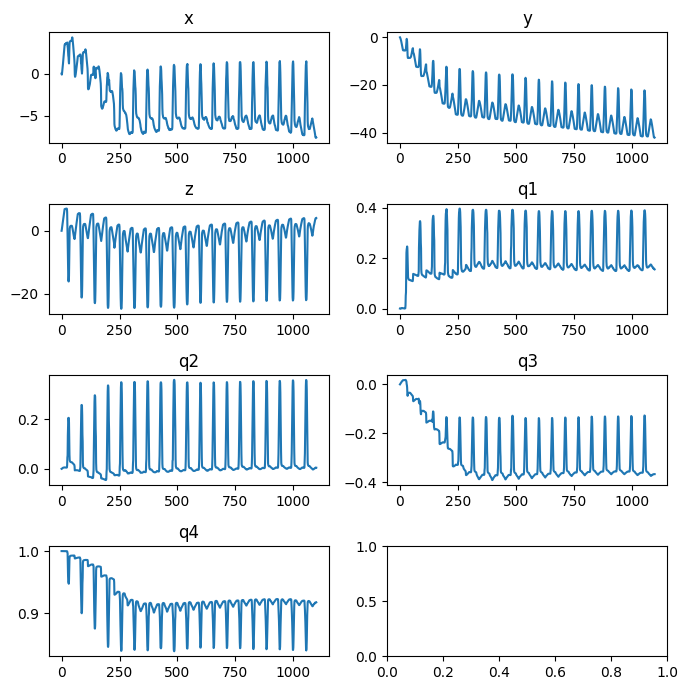

In [ ]:
data100 = data100.drop(data100.index[1100:])
import pandas as pd
import matplotlib.pyplot as plt
#remove data from 1100 to 1200 because of bad acquisition
last_seven_columns = data100.columns[-7:]

fig, axes = plt.subplots(4, 2, figsize=(7,7))  # Adjust figsize as needed

for i, column in enumerate(last_seven_columns):
    ax = axes[i // 2, i % 2]
    data100[column].plot(kind='line', title=column, ax=ax)

plt.tight_layout()
plt.show()

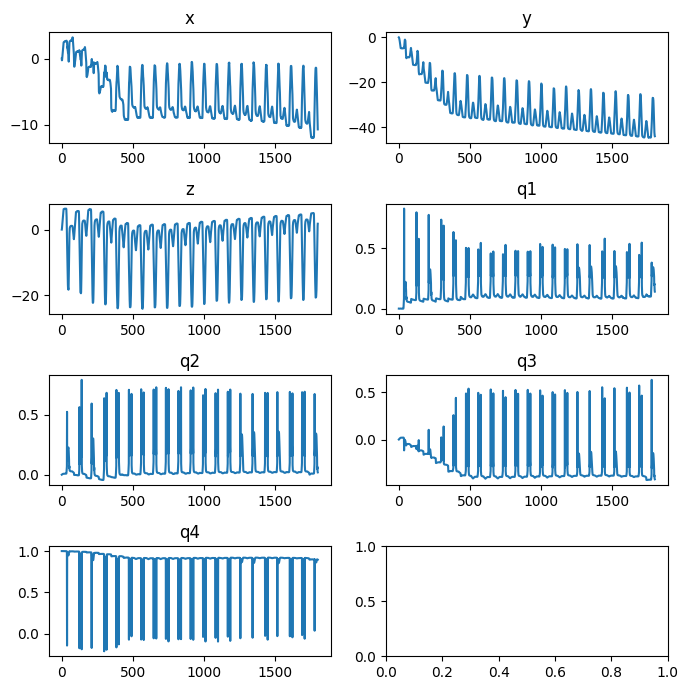

In [ ]:
data50 = data50.drop(data50.index[1800:])

# Plot each column
last_seven_columns = data50.columns[-7:]

fig, axes = plt.subplots(4, 2, figsize=(7,7))  # Adjust figsize as needed

for i, column in enumerate(last_seven_columns):
    ax = axes[i // 2, i % 2]
    data50[column].plot(kind='line', title=column, ax=ax)

plt.tight_layout()
plt.show()

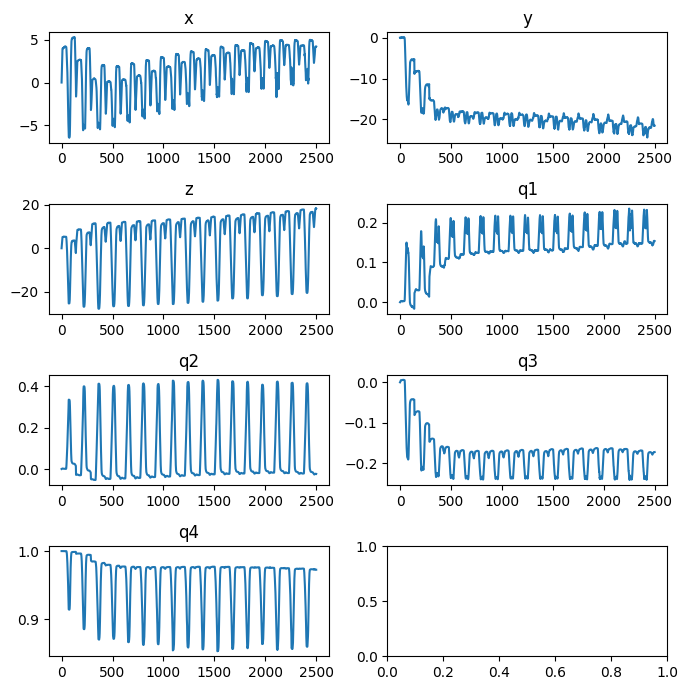

In [ ]:
data25 = data25.drop(data25.index[2500:])
last_seven_columns = data25.columns[-7:]

fig, axes = plt.subplots(4, 2, figsize=(7,7))  # Adjust figsize as needed

for i, column in enumerate(last_seven_columns):
    ax = axes[i // 2, i % 2]
    data25[column].plot(kind='line', title=column, ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
data100

,LIN,ML,AP,x,y,z,q1,q2,q3,q4
0,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
1,0,0,0,-0.126524,-0.195647,0.371246,-0.000208,0.000528,0.001515,0.999999
2,200,0,0,0.034815,-0.393481,1.000663,-0.000768,0.000469,0.003292,0.999994
3,400,0,0,0.296844,-0.724462,1.571550,-0.000035,0.001125,0.004625,0.999989
4,600,0,0,0.576699,-1.088147,2.071307,0.000981,0.002461,0.005573,0.999981
...,...,...,...,...,...,...,...,...,...,...
1095,2200,0,1900,-7.405599,-41.424596,3.674131,0.158928,0.003126,-0.366772,0.916630
1096,2400,0,1900,-7.589370,-42.066467,3.951525,0.156359,0.004916,-0.366709,0.917089
1097,2400,0,1900,-7.535865,-42.021821,3.918354,0.156697,0.004588,-0.366964,0.916931
1098,2400,100,1900,-7.540369,-42.015607,3.981257,0.155812,0.004687,-0.366883,0.917114


## Data preparation


first we split the data into train, validation and test sets

In [ ]:
from sklearn.model_selection import train_test_split

def train_test_split_custom(X, y, test_size):

  # we take the last n rows to include in the train set (so that we scale better)
  n = 5
  X_train_add = X[-n:]
  y_train_add = y[-n:]

  # consequently, we remove these rows from the rest of the data
  X = X[:-n]
  y = y[:-n]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False, random_state=42)
  X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False, random_state=42)

  X_train = pd.concat([X_train, X_train_add])
  y_train = pd.concat([y_train, y_train_add])

  return X_train, X_val, X_test, y_train, y_val, y_test


In [ ]:
X_train_all_unsc = []
y_train_all_unsc = []

X_val_all_unsc = []
y_val_all_unsc = []

X_test_all_unsc = []
y_test_all_unsc = []

In [ ]:
data_list = [data100, data50, data25]

In [ ]:
for i in range(len(data_list)):

  X = data_list[i].iloc[:,3:]
  y = data_list[i].iloc[:,:3]

  X_train, X_val, X_test, y_train, y_val, y_test = train_test_split_custom(X,y,10)

  X_train_all_unsc.append(X_train)
  y_train_all_unsc.append(y_train)

  X_val_all_unsc.append(X_val)
  y_val_all_unsc.append(y_val)

  X_test_all_unsc.append(X_test)
  y_test_all_unsc.append(y_test)

In [ ]:
# putting all train data together, to be used for fitting the scalers
x_train_arr = np.vstack(X_train_all_unsc)
x_train_df = pd.DataFrame(x_train_arr,columns=data100.columns[3:])
y_train_arr = np.vstack(y_train_all_unsc)
y_train_df = pd.DataFrame(y_train_arr,columns=data100.columns[:3])



In [ ]:
X_train_all = []
y_train_all = []
y_train_all_u =[]

X_val_all = []
y_val_all = []
y_val_all_u = []

X_test_all = []
y_test_all = []
y_test_all_u = []

In [ ]:
scaler_pos = MinMaxScaler(feature_range=(0,1))
scaler_motor = MinMaxScaler(feature_range=(0,1))

scaler_pos.fit(x_train_df)
scaler_motor.fit(y_train_df)

# now do scaler.transform for all, keeping them separate
for i in range(len(X_train_all_unsc)):

  X_train_all += [scaler_pos.transform(X_train_all_unsc[i])]
  y_train_all += [scaler_motor.transform(y_train_all_unsc[i])]


  X_val_all += [scaler_pos.transform(X_val_all_unsc[i])]
  y_val_all += [scaler_motor.transform(y_val_all_unsc[i])]

  X_test_all += [scaler_pos.transform(X_test_all_unsc[i])]
  y_test_all += [scaler_motor.transform(y_test_all_unsc[i])]




In [ ]:
# TEST - see if the scaler works
np.allclose(scaler_motor.inverse_transform(y_train_all[0]),y_train_all_unsc[0])

True

In [ ]:
np.min(X_val_all[2])

0.0317897099394431

In [ ]:
y_values_tr = []
y_values_v =[]
y_values_t = []

# Loop through each element in y_train_all
for scaled_values in y_train_all:
    # Apply inverse scaling operation
    y_values_tr.append(scaler_motor.inverse_transform(scaled_values))

for scaled_values in y_test_all:
    # Apply inverse scaling operation
    y_values_t.append(scaler_motor.inverse_transform(scaled_values))

for scaled_values in y_val_all:
    # Apply inverse scaling operation
    y_values_v.append(scaler_motor.inverse_transform(scaled_values))



In [ ]:
X_tr = []
y_tr = []

x_t=[]
y_t=[]

X_v = []
y_v = []

In [ ]:
#compute the input and output data

# Initialize an empty list to store concatenated values
X_t = []

for k in range(3):
    for i in range(len(X_train_all[k])):
    # Initialize an array to hold concatenated values for this element
       input_nnIK = np.zeros([len(X_train_all[k])-1, 17])

       for j in range(len(X_train_all[k])-1):
        # Concatenate the values of current element, corresponding y_train_all[1] value, and next element
          input_nnIK[j] = np.concatenate([X_train_all[k][j], y_train_all[k][j], X_train_all[k][j+1]])

    X_tr.append(input_nnIK)

for k in range(3):
    for i in range(len(X_test_all[k])):
    # Initialize an array to hold concatenated values for this element
       input_nnIK = np.zeros([len(X_test_all[k])-1, 17])

       for j in range(len(X_test_all[k])-1):
        # Concatenate the values of current element, corresponding y_train_all[1] value, and next element
          input_nnIK[j] = np.concatenate([X_test_all[k][j], y_test_all[k][j], X_test_all[k][j+1]])

    X_t.append(input_nnIK)

for k in range(3):
    for i in range(len(X_val_all[k])):
    # Initialize an array to hold concatenated values for this element
       input_nnIK = np.zeros([len(X_val_all[k])-1, 17])

       for j in range(len(X_val_all[k])-1):
        # Concatenate the values of current element, corresponding y_train_all[1] value, and next element
          input_nnIK[j] = np.concatenate([X_val_all[k][j], y_val_all[k][j], X_val_all[k][j+1]])

    X_v.append(input_nnIK)



# Check the sizes of X_train_all[1] and X_t[1] after processing
print("Size of X_train_all[1]:", X_train_all[1].shape)
print("Size of X_tr[1]:", X_tr[1].shape)

print("Size of X_test_all[1]:", X_test_all[1].shape)
print("Size of X_t[1]:", X_t[1].shape)

print("Size of X_val_all[1]:", X_val_all[1].shape)
print("Size of X_v[1]:", X_v[1].shape)


Size of X_train_all[1]: (1433, 7)
Size of X_tr[1]: (1432, 17)
Size of X_test_all[1]: (10, 7)
Size of X_t[1]: (9, 17)
Size of X_val_all[1]: (357, 7)
Size of X_v[1]: (356, 17)


In [ ]:
X_train_all

[array([[0.66884326, 0.99851187, 0.60394022, ..., 0.06280605, 0.43867839,
         1.        ],
        [0.66095563, 0.99407486, 0.61197942, ..., 0.06343042, 0.44025924,
         0.99999918],
        [0.67101367, 0.98958826, 0.62560922, ..., 0.06336065, 0.44211347,
         0.99999506],
        ...,
        [0.19904967, 0.04551404, 0.68879077, ..., 0.06823146, 0.0557657 ,
         0.93153821],
        [0.19876889, 0.04565496, 0.69015291, ..., 0.06834853, 0.05585022,
         0.93168903],
        [0.19606647, 0.04358425, 0.69138374, ..., 0.06797012, 0.05611943,
         0.93183903]]),
 array([[0.66884326, 0.99851187, 0.60394022, ..., 0.06280605, 0.43867839,
         1.        ],
        [0.65279787, 0.99687593, 0.60848713, ..., 0.06402641, 0.44074445,
         0.99999753],
        [0.6539003 , 0.99297828, 0.61882373, ..., 0.06485181, 0.44276667,
         0.99999176],
        ...,
        [0.08364377, 0.01901361, 0.588963  , ..., 0.10885815, 0.01902438,
         0.91616194],
        [0.0

In [ ]:
X_tr

[array([[0.66884326, 0.99851187, 0.60394022, ..., 0.06343042, 0.44025924,
         0.99999918],
        [0.66095563, 0.99407486, 0.61197942, ..., 0.06336065, 0.44211347,
         0.99999506],
        [0.67101367, 0.98958826, 0.62560922, ..., 0.06413639, 0.4435044 ,
         0.99999093],
        ...,
        [0.19571412, 0.04450153, 0.68950907, ..., 0.06823146, 0.0557657 ,
         0.93153821],
        [0.19904967, 0.04551404, 0.68879077, ..., 0.06834853, 0.05585022,
         0.93168903],
        [0.19876889, 0.04565496, 0.69015291, ..., 0.06797012, 0.05611943,
         0.93183903]]),
 array([[0.66884326, 0.99851187, 0.60394022, ..., 0.06402641, 0.44074445,
         0.99999753],
        [0.65279787, 0.99687593, 0.60848713, ..., 0.06485181, 0.44276667,
         0.99999176],
        [0.6539003 , 0.99297828, 0.61882373, ..., 0.06586642, 0.44457082,
         0.99998352],
        ...,
        [0.17780348, 0.03872537, 0.52797171, ..., 0.10885815, 0.01902438,
         0.91616194],
        [0.0

In [ ]:
y_train_all = y_values_tr
y_test_all = y_values_t
y_val_all = y_values_v

In [ ]:
for k in range(3):
    for i in range(len(y_train_all[k])):
    # Initialize an array to hold concatenated values for this element
       input = np.zeros([len(y_train_all[k])-1, 3])

       for j in range(len(y_train_all[k])-1):
        # Concatenate the values of current element, corresponding y_train_all[1] value, and next element
          input[j] = y_train_all[k][j+1]- y_train_all[k][j]

    y_tr.append(input)


for k in range(3):
    for i in range(len(y_test_all[k])):
    # Initialize an array to hold concatenated values for this element
       input = np.zeros([len(y_test_all[k])-1, 3])

       for j in range(len(y_test_all[k])-1):
          input[j] = y_test_all[k][j+1]- y_test_all[k][j]

    y_t.append(input)

for k in range(3):
    for i in range(len(y_val_all[k])):
    # Initialize an array to hold concatenated values for this element
       input = np.zeros([len(y_val_all[k])-1, 3])

       for j in range(len(y_val_all[k])-1):
          input[j] = y_val_all[k][j+1]- y_val_all[k][j]

    y_v.append(input)


print("Size of y_train_all[1]:", y_train_all[1].shape)
print("Size of y_t[1]:", y_tr[1].shape)


Size of y_train_all[1]: (1433, 3)
Size of y_t[1]: (1432, 3)


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
y_t_scaled =[]
y_tr_scaled=[]
y_v_scaled = []

y_tr_arr = np.vstack(y_tr)
y_train_df = pd.DataFrame(y_train_arr,columns=['col1','col2','col3'])

# Generating column labels for the DataFrame
columns_labels = [f'col_{i}' for i in range(3)]

# Creating DataFrame with appropriate column labels
y_tr_df = pd.DataFrame(y_tr_arr, columns=columns_labels)

# Fitting the scaler
scaler.fit_transform(y_tr_df)

for i in range(len(y_t)):

    y_t_scaled += [scaler.transform(y_t[i])]
    y_v_scaled += [scaler.transform(y_v[i])]
    y_tr_scaled += [scaler.transform(y_tr[i])]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScal

In [ ]:
y_tr_scaled

[array([[0.5       , 0.91666667, 0.        ],
        [1.        , 0.91666667, 0.        ],
        [1.        , 0.91666667, 0.        ],
        ...,
        [0.5       , 0.91666667, 0.        ],
        [0.5       , 1.        , 0.        ],
        [0.5       , 1.        , 0.        ]]),
 array([[0.5       , 0.91666667, 0.        ],
        [1.        , 0.91666667, 0.        ],
        [1.        , 0.91666667, 0.        ],
        ...,
        [0.5       , 0.875     , 0.        ],
        [0.5       , 0.875     , 0.        ],
        [0.5       , 0.875     , 0.        ]]),
 array([[0.5       , 0.91666667, 0.        ],
        [1.        , 0.91666667, 0.        ],
        [1.        , 0.91666667, 0.        ],
        ...,
        [0.5       , 0.9375    , 0.        ],
        [0.5       , 0.9375    , 0.        ],
        [0.5       , 0.9375    , 0.        ]])]

In [ ]:
len(X_train_all[1])


1433

In [ ]:
print(X_train_all)

[array([[0.66884326, 0.99851187, 0.60394022, ..., 0.06280605, 0.43867839,
        1.        ],
       [0.66095563, 0.99407486, 0.61197942, ..., 0.06343042, 0.44025924,
        0.99999918],
       [0.67101367, 0.98958826, 0.62560922, ..., 0.06336065, 0.44211347,
        0.99999506],
       ...,
       [0.19904967, 0.04551404, 0.68879077, ..., 0.06823146, 0.0557657 ,
        0.93153821],
       [0.19876889, 0.04565496, 0.69015291, ..., 0.06834853, 0.05585022,
        0.93168903],
       [0.19606647, 0.04358425, 0.69138374, ..., 0.06797012, 0.05611943,
        0.93183903]]), array([[0.66884326, 0.99851187, 0.60394022, ..., 0.06280605, 0.43867839,
        1.        ],
       [0.65279787, 0.99687593, 0.60848713, ..., 0.06402641, 0.44074445,
        0.99999753],
       [0.6539003 , 0.99297828, 0.61882373, ..., 0.06485181, 0.44276667,
        0.99999176],
       ...,
       [0.08364377, 0.01901361, 0.588963  , ..., 0.10885815, 0.01902438,
        0.91616194],
       [0.0210881 , 0.00563841, 0

In [ ]:
X_train= np.vstack(X_tr)
y_train = np.vstack(y_tr_scaled)

X_val= np.vstack(X_v)
y_val = np.vstack(y_v_scaled)


X_test = np.vstack(X_t)
y_test = np.vstack(y_t_scaled)


In [ ]:
#input_shape = X_tr.shape[1:3]
#output_shape = y_tr_scaled.shape[1:3]
#print(input_shape, output_shape)
print(X_train_all[0].size)

6111


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from kerastuner.tuners import RandomSearch
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam

<ipython-input-42-1145212fb37b>:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

def build_model(hp):
    model = keras.Sequential()
    activation_functions = ['relu', 'tanh', 'swish', 'elu', 'sigmoid']

    # Increase the number of hidden layers (1 to 5)
    for i in range(hp.Int('num_layers', 1, 5)):
        units = hp.Int('units_' + str(i), min_value=24, max_value=128, step=4)
        activation = hp.Choice('activation_' + str(i), activation_functions)
        model.add(layers.Dense(units=units, activation=activation))

    # Additional Hidden Layer 1
    units_layer1 = hp.Int('units_layer1', min_value=24, max_value=128, step=4)
    activation_layer1 = hp.Choice('activation_layer1', activation_functions)
    model.add(layers.Dense(units=units_layer1, activation=activation_layer1))

    # Additional Hidden Layer 2
    units_layer2 = hp.Int('units_layer2', min_value=24, max_value=128, step=4)
    activation_layer2 = hp.Choice('activation_layer2', activation_functions)
    model.add(layers.Dense(units=units_layer2, activation=activation_layer2))

    # Dropout layer (you can adjust the rate if needed)
    model.add(layers.Dropout(0.2))

    # Output layer (linear activation for regression, adjust for your task)
    model.add(layers.Dense(3, activation='linear'))

    # Compile the model (learning rate choice expanded)
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', [0.001, 0.005, 0.01, 0.1])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error']
    )

    return model



In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=500,
    executions_per_trial=1,
    overwrite=True)

tuner.search_space_summary()
#start the hyperparameters search

cb_early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
cb_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=7, factor=0.1, min_lr=1e-5)

tuner.search(X_train, y_train,
             epochs=100,
             validation_split=0.2,
             callbacks=[cb_early_stop, cb_lr])
tuner.results_summary()


Trial 500 Complete [00h 00m 17s]
val_loss: 0.034900300204753876

Best val_loss So Far: 0.013638870790600777
Total elapsed time: 01h 27m 07s
Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 090 summary
Hyperparameters:
num_layers: 1
units_0: 116
activation_0: relu
units_layer1: 108
activation_layer1: relu
units_layer2: 32
activation_layer2: relu
learning_rate: 0.001
units_1: 120
activation_1: tanh
units_2: 72
activation_2: swish
units_3: 68
activation_3: elu
units_4: 88
activation_4: swish
Score: 0.013638870790600777

Trial 033 summary
Hyperparameters:
num_layers: 4
units_0: 116
activation_0: elu
units_layer1: 116
activation_layer1: tanh
units_layer2: 100
activation_layer2: relu
learning_rate: 0.001
units_1: 72
activation_1: elu
units_2: 124
activation_2: relu
units_3: 28
activation_3: tanh
units_4: 80
activation_4: relu
Score: 0.018261579796671867

Trial 419 summary
Hyperparameters:
num_layers: 4
units_0: 76
activat

if necessary, we can turn window/stride into a list to choose size according to the dataset

note: the test set is too small to use windows of size 20

##### with functions - currently not used

In [ ]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2)
val_loss_epoch = history.history['val_loss']
best_epoch = val_loss_epoch.index(min(val_loss_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

model = tuner.hypermodel.build(best_hps)

#  Retrain the model
model.fit(X_train, y_train, epochs=best_epoch, validation_split=0.2)
# evaluate test set
eval_result = model.evaluate(X_test, y_test)
print("loss test result: ", eval_result[0])

In [ ]:
best_epoch = np.argmin(history.history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history.history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history.history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()
print()

In [ ]:
# evaluate test set step error
predictions = model.predict(X_test)
test_unscaled = scaler.inverse_transform(predictions)
y_test_unscaled = scaler.inverse_transform(y_test)
error = np.zeros(3)
for i in range(3):
    error[i] = sklearn.metrics.mean_absolute_error(y_test_unscaled[:,i] ,test_unscaled[:,i])
print('Mean err new data',error)



In [ ]:
np.mean(error) #number unscaled  motor steps error (small)

6.297750858222078

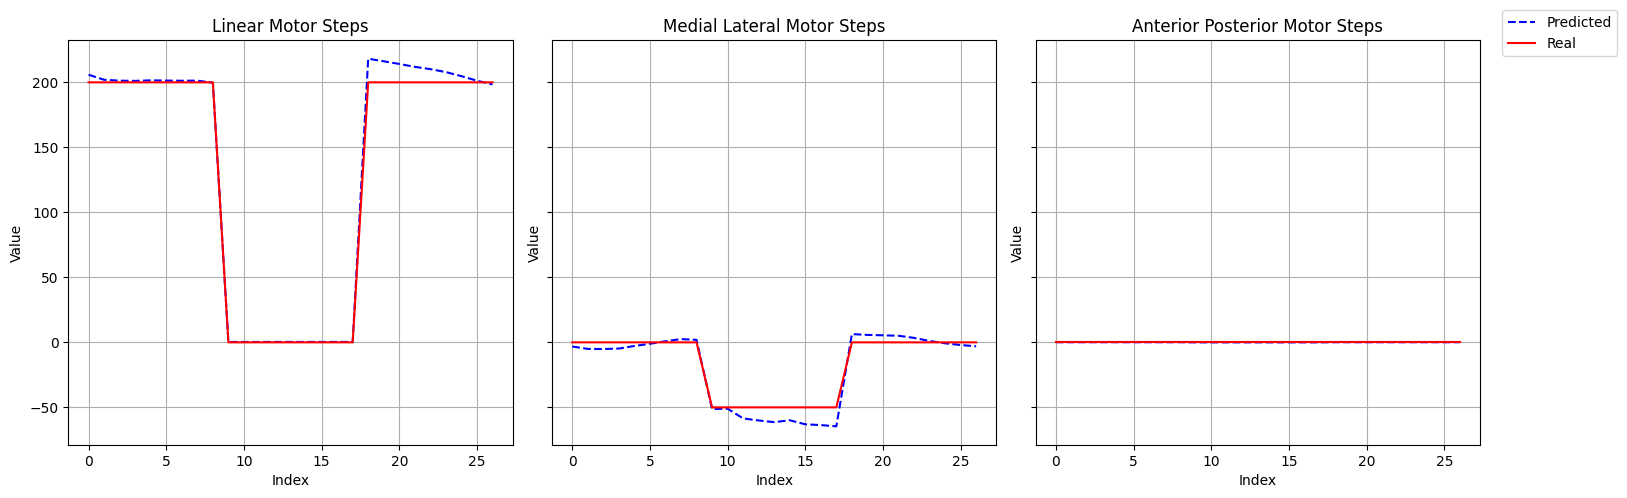

In [ ]:
import matplotlib.pyplot as plt

# Assuming test_unscaled and y_test_unscaled are numpy arrays

# Create subplots with shared y-axis
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot for each column
for i, motor_step in enumerate(['Linear', 'Medial Lateral', 'Anterior Posterior']):
    axs[i].plot(test_unscaled[:, i], color='b', linestyle='--', label='Predicted')
    axs[i].plot(y_test_unscaled[:, i], color='r', label='Real')  # Dotted line

    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')
    axs[i].set_title(f'{motor_step} Motor Steps')
    axs[i].legend().set_visible(False)  # Hide legend in each subplot
    axs[i].grid(True)

# Create a single legend
fig.legend(loc='upper left', bbox_to_anchor=(1, 1), labels=['Predicted', 'Real'])

plt.tight_layout()
plt.show()


### save model

In [ ]:
#save model
# model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
import time
name = 'model_FFNN_1502_'
model.save(f'/models/{name}')

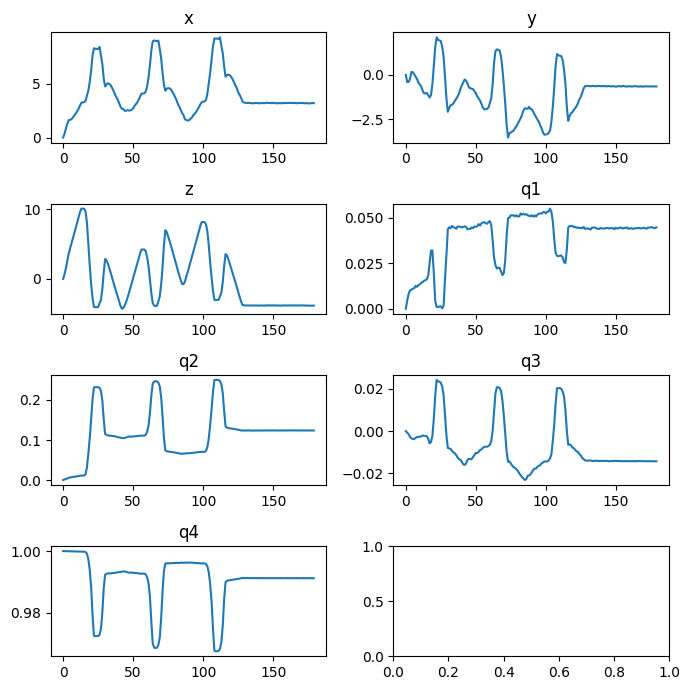

In [ ]:
#load final test set
test = pd.read_excel('data/test_transf.xlsx')


import matplotlib.pyplot as plt

last_seven_columns = test.columns[-7:]

fig, axes = plt.subplots(4, 2, figsize=(7,7))  # Adjust figsize as needed

for i, column in enumerate(last_seven_columns):
    ax = axes[i // 2, i % 2]
    test[column].plot(kind='line', title=column, ax=ax)

plt.tight_layout()
plt.show()

In [ ]:
# apply transformations and scaling

x_test = test.iloc[:,3:]
y_test = test.iloc[:,:3]

mot_test= scaler_motor.transform(y_test)
pose_test = scaler_pos.transform(x_test)
y_test = scaler_motor.inverse_transform(mot_test)



In [ ]:
X_test = []
for j in range(len(mot_test)-1):
    X_test.append(np.concatenate([pose_test[j], mot_test[j], pose_test[j+1]]))

Y_test = []
for j in range(len(mot_test)-1):
  Y_test.append(y_test[j+1] - y_test[j])

y_test_scaled = scaler.transform(Y_test)




/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [ ]:
# evaluate test set step error
X_test = np.vstack(X_test)

test = model.predict(X_test)
test_unscaled = scaler.inverse_transform(test)
y_test_fin = np.vstack(Y_test)
error = np.zeros(3)
for i in range(3):
    error[i] = sklearn.metrics.mean_absolute_error(y_test_fin[:,i] ,test_unscaled[:,i])
print('Mean err new data',error)


6/6 [==============================] - 0s 3ms/step
Mean err new data [61.70909893 66.19057032  0.92224278]


In [ ]:
np.mean(error)

42.940637340550644

In [ ]:
""""
import matplotlib.pyplot as plt

# Assuming test_unscaled and y_test_unscaled are numpy arrays
plt.plot(y_test_fin[:,1], color='b')
plt.plot(test_unscaled[:,1], color='r')

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of Predicted and Real Values')
plt.legend('Predicted', 'Real')
plt.grid(True)
plt.show()
for i in range(20):
  print(f'predicted: {test_unscaled[i]} -- real: {y_test_fin[i]}')
"""

'"\nimport matplotlib.pyplot as plt\n\n# Assuming test_unscaled and y_test_unscaled are numpy arrays\nplt.plot(y_test_fin[:,1], color=\'b\')\nplt.plot(test_unscaled[:,1], color=\'r\')\n  \nplt.xlabel(\'Index\')\nplt.ylabel(\'Value\')\nplt.title(\'Comparison of Predicted and Real Values\')\nplt.legend(\'Predicted\', \'Real\')\nplt.grid(True)\nplt.show()\nfor i in range(20):\n  print(f\'predicted: {test_unscaled[i]} -- real: {y_test_fin[i]}\')\n'